# Mounting GDrive directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_8/Capstone1_Ad_Campaign_Recommender/'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_8/Capstone1_Ad_Campaign_Recommender


# Import libraries

In [ ]:
%pip install basemap awscli --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
import os
import csv

from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Subtask 1: Reading data

- [app_events.csv](https://uoacapstone.s3.amazonaws.com/app_events.csv)
- [train_event_data.csv](https://uoacapstone.s3.amazonaws.com/train_event_data.csv)
- [app_events_meta_data.csv](https://uoacapstone.s3.amazonaws.com/app_events_meta_data.csv)
- [train_mobile_brand.csv](https://uoacapstone.s3.amazonaws.com/train_mobile_brand.csv)

In [ ]:
datasets = {
  'app_events.csv' : 's3://uoacapstone/app_events.csv',
  'train_event_data.csv' : 's3://uoacapstone/train_event_data.csv',
  'app_events_meta_data.csv' : 's3://uoacapstone/app_events_meta_data.csv',
  'train_mobile_brand.csv' : 's3://uoacapstone/train_mobile_brand.csv',
}

In [ ]:
# Download datasets if not already downloaded
for k,v in datasets.items():
  if not os.path.exists(f'data/{k}'):
    !aws s3 cp "$v" "data/$k" --no-sign-request

download: s3://uoacapstone/app_events.csv to data/app_events.csv    
download: s3://uoacapstone/train_event_data.csv to data/train_event_data.csv
download: s3://uoacapstone/app_events_meta_data.csv to data/app_events_meta_data.csv
download: s3://uoacapstone/train_mobile_brand.csv to data/train_mobile_brand.csv


In [ ]:
# Load into dataframes, disble quote parsing inside strings when loading
# Ref: https://stackoverflow.com/a/29857126

app_events = pd.read_csv('data/app_events.csv', quoting=csv.QUOTE_NONE)
train_event_data = pd.read_csv('data/train_event_data.csv', quoting=csv.QUOTE_NONE)
app_events_meta_data = pd.read_csv('data/app_events_meta_data.csv', quoting=csv.QUOTE_NONE)
train_mobile_brand = pd.read_csv('data/train_mobile_brand.csv', quoting=csv.QUOTE_NONE)

# Subtask 2: Cleaning data

## Show some records

In [ ]:
for df, label in zip(
    [
        app_events,
        train_event_data,
        app_events_meta_data,
        train_mobile_brand,
    ],
    [
        'app_events',
        'train_event_data',
        'app_events_meta_data',
        'train_mobile_brand',
    ],
):
  display(HTML(f'<h2>{label}</h2>'))
  display(df.head(5))
  display(HTML('<hr/>'))

,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude
0,-7548291590301750000,M,33,M32+,2369465.0,2016-05-03 15:55:35,33.98,116.79
1,-7548291590301750000,M,33,M32+,1080869.0,2016-05-03 06:07:16,33.98,116.79
2,-7548291590301750000,M,33,M32+,1079338.0,2016-05-04 03:28:02,33.98,116.79
3,-7548291590301750000,M,33,M32+,1078881.0,2016-05-04 02:53:08,33.98,116.79
4,-7548291590301750000,M,33,M32+,1068711.0,2016-05-03 15:59:35,33.98,116.79


,app_id,label_id,category
0,app_id,label_id,category
1,7324884708820027918,251,Finance
2,-4494216993218550286,251,Finance
3,6058196446775239644,406,unknown
4,6058196446775239644,407,DS_P2P net loan


,device_id,gender,age,group_train,phone_brand,device_model
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C
1,6943568600617760000,M,37,M32+,Xiaomi,xnote
2,5441349705980020000,M,40,M32+,OPPO,R7s
3,-5393876656119450000,M,33,M32+,Xiaomi,MI 4
4,4543988487649880000,M,53,M32+,samsung,Galaxy S4


## Check data types and missing values

In [ ]:
for df, label in zip(
    [
        app_events,
        train_event_data,
        app_events_meta_data,
        train_mobile_brand,
    ],
    [
        'app_events',
        'train_event_data',
        'app_events_meta_data',
        'train_mobile_brand',
    ],
):
  display(HTML(f'<h2>{label}</h2>'))
  display(df.info())
  display(HTML('<hr/>'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   event_id      int64
 1   app_id        int64
 2   is_installed  int64
 3   is_active     int64
dtypes: int64(4)
memory usage: 991.0 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   device_id      1266933 non-null  int64  
 1   gender         1266933 non-null  object 
 2   age            1266933 non-null  int64  
 3   group_train    1266933 non-null  object 
 4   event_id       1215598 non-null  float64
 5   datetimestamp  1215598 non-null  object 
 6   latitude       1215598 non-null  float64
 7   longitude      1215598 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 77.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459944 entries, 0 to 459943
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   app_id    459944 non-null  object
 1   label_id  459944 non-null  object
 2   category  459944 non-null  object
dtypes: object(3)
memory usage: 10.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74840 entries, 0 to 74839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     74840 non-null  int64 
 1   gender        74840 non-null  object
 2   age           74840 non-null  int64 
 3   group_train   74840 non-null  object
 4   phone_brand   74840 non-null  object
 5   device_model  74840 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


None

For labels columns `gender` and `age`, assume there is no mismatch of labels in records with the same device id.

For other columns in the datasets, only `train_event_data` has missing values, and we can easily see that for many records there aren't associated events with them. Let's check again to make sure the missing events and related data are on the same records.

In [ ]:
train_event_data[train_event_data['event_id'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51335 entries, 1215595 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   device_id      51335 non-null  int64  
 1   gender         51335 non-null  object 
 2   age            51335 non-null  int64  
 3   group_train    51335 non-null  object 
 4   event_id       0 non-null      float64
 5   datetimestamp  0 non-null      object 
 6   latitude       0 non-null      float64
 7   longitude      0 non-null      float64
dtypes: float64(3), int64(2), object(3)
memory usage: 3.5+ MB


That is correct, so there is no missing data in the input datasets

Let's see how many unique device ids that we have:

In [ ]:
for df, label in zip(
    [
        train_event_data,
        train_mobile_brand,
        pd.merge(train_event_data, train_mobile_brand, on='device_id', how='outer')
    ],
    [
        'train_event_data',
        'train_mobile_brand',
        'merged',
    ],
):
  display(HTML(f'<h2>{label} unique devices:</h2>'))
  display(df['device_id'].nunique())
  display(HTML('<hr/>'))

74645

74645

74645

The devices are the same in both train datasets.

The remaining cleaning is to cast datetime to correct data type

In [ ]:
train_event_data['datetimestamp'] = pd.to_datetime(train_event_data['datetimestamp'])

In [ ]:
train_event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1266933 non-null  int64         
 1   gender         1266933 non-null  object        
 2   age            1266933 non-null  int64         
 3   group_train    1266933 non-null  object        
 4   event_id       1215598 non-null  float64       
 5   datetimestamp  1215598 non-null  datetime64[ns]
 6   latitude       1215598 non-null  float64       
 7   longitude      1215598 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 77.3+ MB


## Check statistics for invalid records

In [ ]:
for df, label in zip(
    [
        app_events,
        train_event_data,
        app_events_meta_data,
        train_mobile_brand,
    ],
    [
        'app_events',
        'train_event_data',
        'app_events_meta_data',
        'train_mobile_brand',
    ],
):
  display(HTML(f'<h2>{label}</h2>'))
  display(df.describe())
  display(HTML('<h3>unique values:</h3>'))
  display(df.nunique())
  display(HTML('<hr/>'))

,event_id,app_id,is_installed,is_active
count,3.247307e+07,3.247307e+07,32473067.0,3.247307e+07
mean,1.625564e+06,1.182779e+18,1.0,3.921094e-01
std,9.384682e+05,5.360173e+18,0.0,4.882209e-01
min,2.000000e+00,-9.221157e+18,1.0,0.000000e+00
25%,8.134720e+05,-3.474568e+18,1.0,0.000000e+00
50%,1.626907e+06,1.387044e+18,1.0,0.000000e+00
75%,2.441106e+06,6.043001e+18,1.0,1.000000e+00
max,3.252948e+06,9.222488e+18,1.0,1.000000e+00


event_id        1488096
app_id            19237
is_installed          1
is_active             2
dtype: int64

,device_id,age,event_id,latitude,longitude
count,1.266933e+06,1.266933e+06,1.215598e+06,1.215598e+06,1.215598e+06
mean,-2.967925e+16,3.340051e+01,1.626675e+06,2.182751e+01,7.839380e+01
std,5.322606e+18,9.762003e+00,9.396631e+05,1.564827e+01,5.381246e+01
min,-9.223067e+18,1.000000e+00,1.000000e+00,-3.380000e+01,-1.800000e+02
25%,-4.668347e+18,2.600000e+01,8.123205e+05,0.000000e+00,0.000000e+00
50%,-1.115514e+17,3.100000e+01,1.627310e+06,2.857000e+01,1.127500e+02
75%,4.631837e+18,3.900000e+01,2.440380e+06,3.401000e+01,1.171700e+02
max,9.222849e+18,9.600000e+01,3.252948e+06,5.364000e+01,1.511800e+02


device_id          74645
gender                 2
age                   85
group_train            6
event_id         1215598
datetimestamp     497663
latitude            2707
longitude           2914
dtype: int64

,app_id,label_id,category
count,459944,459944,459944
unique,165044,554,472
top,-4550209074213737101,405,Industry tag
freq,22,49391,56902


app_id      165044
label_id       554
category       472
dtype: int64

,device_id,age
count,7.484000e+04,74840.000000
mean,2.381650e+14,31.407924
std,5.327486e+18,9.867279
min,-9.223067e+18,1.000000
25%,-4.617637e+18,25.000000
50%,-1.831665e+16,29.000000
75%,4.638645e+18,36.000000
max,9.222849e+18,96.000000


device_id       74645
gender              2
age                85
group_train         6
phone_brand        97
device_model     1438
dtype: int64

The input data contains valid values but the age range is questionable since minimum age in data is 1 year old.

For coordinate, latitude is within range of [-90, 90] and longitude is withing range [-180, 180] so they are valid values (reference: https://developers.google.com/maps/documentation/javascript/reference/coordinates).

# Subtask 3: Basic EDA and visualization and feature engineering ideas

## 1. Age and gender distribution

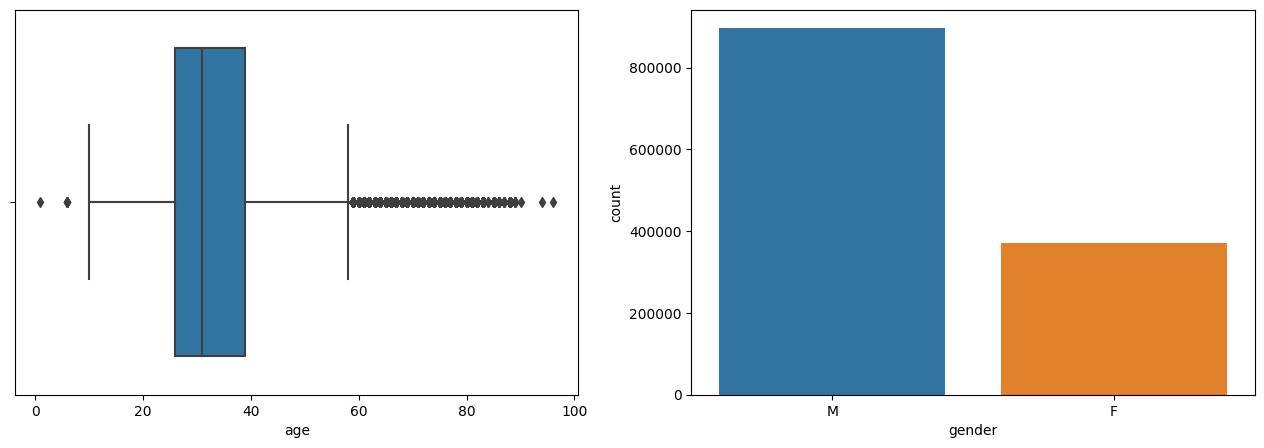

In [ ]:
# Univariate analysis of age and gender

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

sns.boxplot(train_event_data, x="age", ax=ax1)
sns.countplot(train_event_data, x='gender', ax=ax2)

plt.show()

Most of the data points are people of young age around 20 - 40. Although there is a questionable outliers of "baby" users, we will ignore it for now as it may still be a valid label depends on the domain and labeling rules.

There is an imbalance in gender between male and female. The data points from male users are double the data points from female.

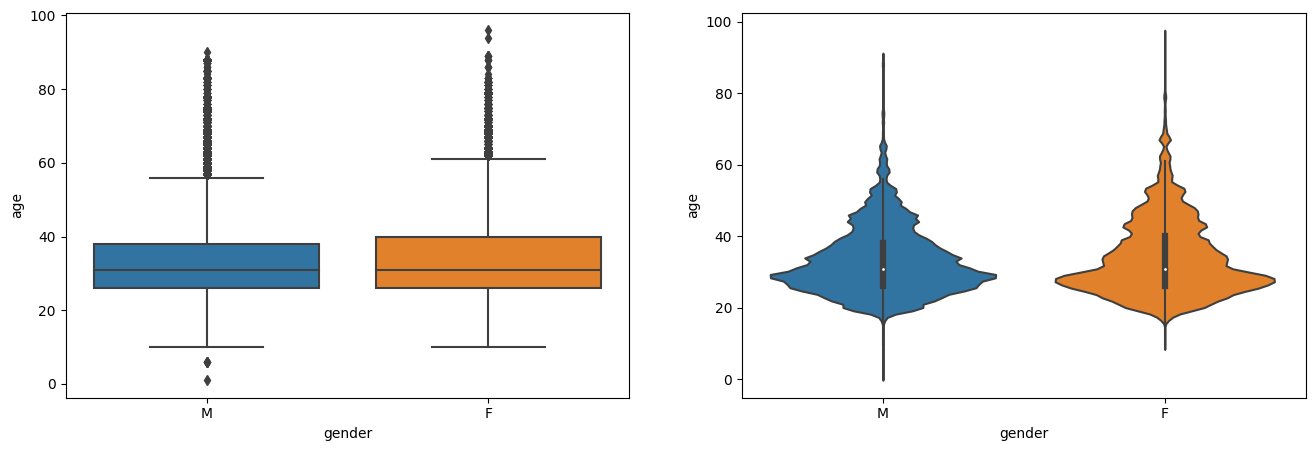

In [ ]:
# Bivariate analysis between age and gender

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

sns.boxplot(train_event_data, x='gender', y='age', ax=ax1)
sns.violinplot(train_event_data, x='gender', y='age', ax=ax2)

plt.show()

Male users tend to be a little younger than female users. The majority of users in both male and female groups are young ones.

There are some "baby" users in the male group, possibly due to wrong label. Since they are outliers, we may ignore them for now.

## 2. Trends in event data

### a) Percentage of device ids with and without event data

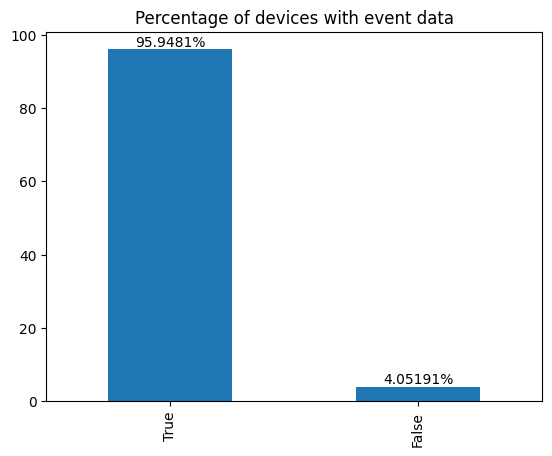

In [ ]:
# Filter out records with empty event_id
devices_with_event_data = (~train_event_data['event_id'].isna())
ax = (
    devices_with_event_data.value_counts() * 100 / devices_with_event_data.count()
).plot.bar()
ax.bar_label(ax.containers[0], fmt='%g%%')
plt.title('Percentage of devices with event data')
plt.show()

There is only around 4.05% of devices are without event data

### b) Distribution of events on different days of week

In [ ]:
# Filter out records with empty event_id
events_per_weekday = train_event_data[~train_event_data['event_id'].isna()]
# Get day of week from timestamp
events_per_weekday['Day of week'] = (
    events_per_weekday['datetimestamp']
      .apply(lambda d: d.dayofweek)
)
# Count events on each day of week
events_per_weekday = events_per_weekday.groupby('Day of week')['event_id'].count()
# Reset index after grouping to flatten columns
events_per_weekday = events_per_weekday.rename('event_count').reset_index()
events_per_weekday

,Day of week,event_count
0,0,169381
1,1,180296
2,2,178371
3,3,180041
4,4,176657
5,5,166835
6,6,164017


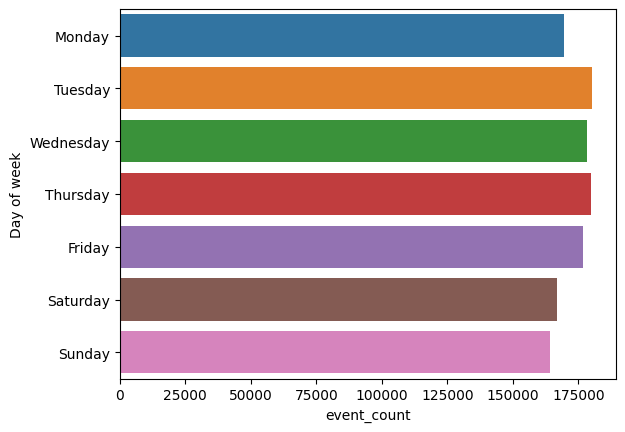

In [ ]:
ax = sns.barplot(events_per_weekday, y='Day of week', x='event_count', orient='h')
# Map day of week indexes to labels
ax.set_yticks(
    range(7),
    labels=[
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday',
    ]
)
plt.show()

There events are distributed equally over days of week.

### c) Distribution of events per hour for one week data

Let's see the distribution of events over entire dataset and pick one week to see hourly event frequency.

In [ ]:
# Filter out records with empty event_id
hourly_event_data = train_event_data[~train_event_data['event_id'].isna()]
# Normalize the timestamp to hour unit
hourly_event_data['datetimestamp'] = hourly_event_data['datetimestamp'].dt.to_period('H')
# Count events for each hour in whole dataset
hourly_event_data = hourly_event_data.groupby('datetimestamp')['event_id'].count()
hourly_event_data.to_frame()

,event_id
datetimestamp,
2016-04-30 23:00,378
2016-05-01 00:00,6689
2016-05-01 01:00,3961
2016-05-01 02:00,3130
2016-05-01 03:00,2612
...,...
2016-05-07 20:00,8769
2016-05-07 21:00,9529
2016-05-07 22:00,8638


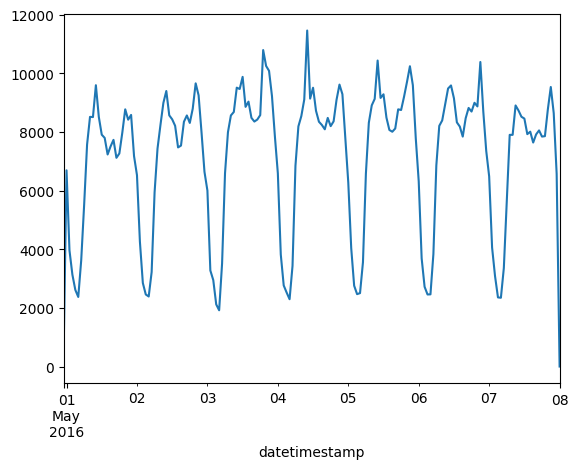

In [ ]:
hourly_event_data.plot.line()
plt.show()

The dataset is already collected within 1 week time range. Let's see the distribution of events hourly for every day in a week.

In [ ]:
# Filter out records with empty event_id
one_week_hourly_event_data = train_event_data[~train_event_data['event_id'].isna()]
# Normalize the timestamp to hour unit
one_week_hourly_event_data['datetimestamp'] = (
    one_week_hourly_event_data['datetimestamp'].dt.to_period('H')
)
# Group by hour of the day and count events
one_week_hourly_event_data_by_hour = (
    one_week_hourly_event_data
      .groupby(one_week_hourly_event_data['datetimestamp'].dt.hour)['event_id']
      .count()
      .reset_index()
      .rename(columns={'datetimestamp': 'Hour of day', 'event_id': 'event_count'})
)
one_week_hourly_event_data_by_hour

,Hour of day,event_count
0,0,44864
1,1,27090
2,2,20248
3,3,16991
4,4,16282
5,5,24536
6,6,43970
7,7,55583
8,8,59032
9,9,62226


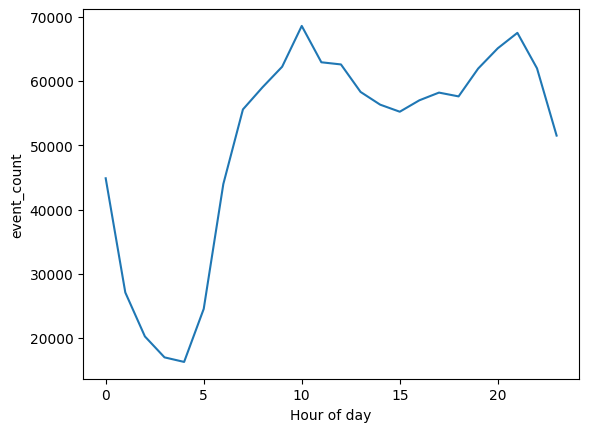

In [ ]:
sns.lineplot(one_week_hourly_event_data_by_hour, x='Hour of day', y='event_count')
plt.show()

There is a period of low activity during 0h to 5h everyday.

### d) Difference in the distribution of events per hour for males and females

In [ ]:
# From hourly event data, group by hour of day and gender
hourly_event_by_gender = one_week_hourly_event_data.groupby(
    [
        one_week_hourly_event_data['datetimestamp'].dt.hour,
        'gender',
    ]
)
# Count the events and then flatten columns
hourly_event_by_gender = hourly_event_by_gender['event_id'].count().reset_index()
hourly_event_by_gender = hourly_event_by_gender.rename(columns={
    'datetimestamp': 'Hour of day',
    'event_id': 'event_count',
})
hourly_event_by_gender

,Hour of day,gender,event_count
0,0,F,11004
1,0,M,33860
2,1,F,6693
3,1,M,20397
4,2,F,5241
5,2,M,15007
6,3,F,4424
7,3,M,12567
8,4,F,4561
9,4,M,11721


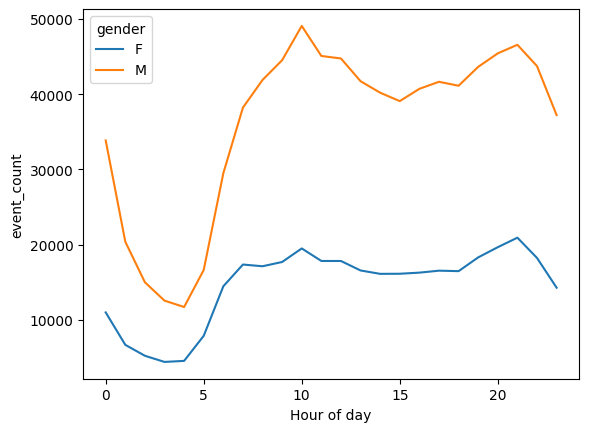

In [ ]:
sns.lineplot(hourly_event_by_gender, x='Hour of day', y='event_count', hue='gender')
plt.show()

The event frequency of events generated from male user group is higher than female users.

Male users are very active at 10AM. Both male and female are active at around 9PM.

The frequency of events generated from female users are stable from morning to afternoon.

### e) Difference in the distribution of events for different age groups over different days of week

In [ ]:
# Filter out records with empty event_id
age_group_events_per_weekday = train_event_data[~train_event_data['event_id'].isna()]
# Get day of week from timestamp
age_group_events_per_weekday['Day of week'] = (
    age_group_events_per_weekday['datetimestamp'].apply(lambda d: d.dayofweek)
)
# Create bins of age groups: 0–24, 25–32, 33–45, 46+
age_group_events_per_weekday['age_bin'] = pd.cut(
    age_group_events_per_weekday['age'],
    [0, 24, 32, 45, 100],
)
# Count events per day of week for each age bin
age_group_events_per_weekday = age_group_events_per_weekday.groupby(['Day of week', 'age_bin'])['event_id'].count()
age_group_events_per_weekday = age_group_events_per_weekday.reset_index().rename(columns={'event_id': 'event_count'})
age_group_events_per_weekday

,Day of week,age_bin,event_count
0,0,"(0, 24]",27123
1,0,"(24, 32]",65877
2,0,"(32, 45]",55232
3,0,"(45, 100]",21149
4,1,"(0, 24]",26144
5,1,"(24, 32]",71487
6,1,"(32, 45]",59882
7,1,"(45, 100]",22783
8,2,"(0, 24]",27114
9,2,"(24, 32]",69098


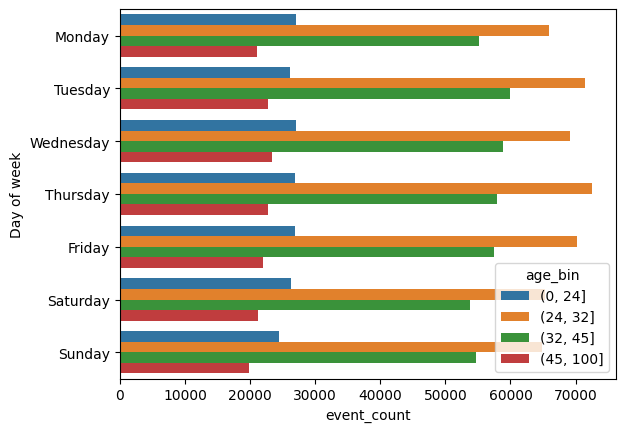

In [ ]:
ax = sns.barplot(age_group_events_per_weekday, y='Day of week', x='event_count', hue='age_bin', orient='h')
# Map day of week indexes to labels
ax.set_yticks(
    range(7),
    labels=[
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday',
    ]
)
plt.show()

The general trends are not different much between age groups. But, looking at the frequency, the most active age group are persons of age from 25 to 32 years old and decreasing futher to both sides (younger and older).

## 3. Phone Brand and Application Preferences

### a) Top 10 mobile brands across male and female consumers

In [ ]:
# Group devices by gender and phone brand then count them
phone_brand_count = train_mobile_brand.groupby(['gender', 'phone_brand'])['phone_brand'].count()
# Get top 10 brands per gender
top_brands_by_gender = phone_brand_count.groupby('gender').nlargest(10)
# We got duplicate index, so just drop one of them
top_brands_by_gender = top_brands_by_gender.droplevel(0)
# Swap index gender↔phone_brand
top_brands_by_gender = top_brands_by_gender.swaplevel(0,1)
# Sort descending in order to plot
top_brands_by_gender = top_brands_by_gender.unstack().sort_values(by=['F', 'M'], ascending=False)
top_brands_by_gender

gender,F,M
phone_brand,,
Xiaomi,5930,11407
samsung,5443,8263
Huawei,4257,8744
vivo,2660,2998
OPPO,2581,3221
Meizu,1306,3404
Coolpad,1079,2270
lenovo,894,1801
Gionee,403,721


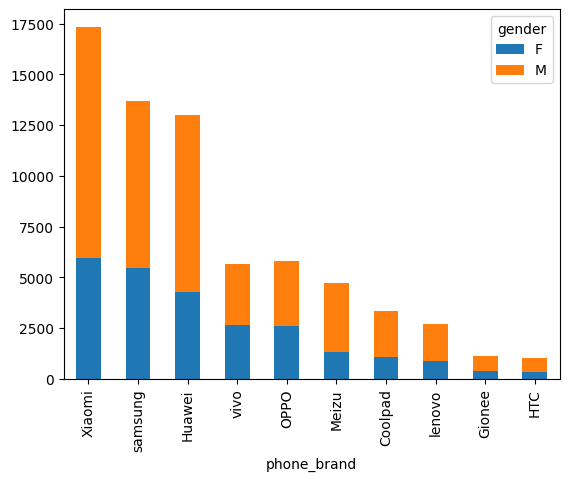

In [ ]:
top_brands_by_gender.plot.bar(stacked=True)
plt.show()

Xiaomi is the most popular brand for both male and female, followed by Samsung in the second place.

### b) Top 10 frequent applications and the corresponding percentage of male and female consumers

In [ ]:
# Merge train_event_data and app_events to have app_id in dataframe
top_frequent_apps = pd.merge(
    # Filter out records with empty event_id
    train_event_data[~train_event_data['event_id'].isna()]['event_id'],
    app_events[['event_id', 'app_id']],
    on='event_id',
    how='inner',
)
# Just use 2 columns of interest
top_frequent_apps = top_frequent_apps[['event_id', 'app_id']]
# Group and count events per app and keep top 10 apps
top_frequent_apps = top_frequent_apps.groupby('app_id').count().nlargest(10, ['event_id'])
# Reset index to flatten columns
top_frequent_apps = top_frequent_apps.reset_index().rename(columns={'event_id': 'event_count'})
# Mege with metadata to get the categories
top_frequent_apps = pd.merge(top_frequent_apps, app_events_meta_data[['app_id', 'category']], on='app_id', how='left')
# Only use 3 columns of interest
top_frequent_apps = top_frequent_apps[['app_id', 'event_count', 'category']]
# Grouping before aggregating the categories
top_frequent_apps = top_frequent_apps.groupby(['app_id', 'event_count'])['category']
# Aggregate categories into lists and flatten columns again
top_frequent_apps = top_frequent_apps.apply(list).reset_index()
# Sort descending in order to plot
top_frequent_apps = top_frequent_apps.sort_values(by='event_count', ascending=False)
# Cast column app_id to string in order to keep ordering when plotting
top_frequent_apps['app_id'] = top_frequent_apps['app_id'].astype(str)
top_frequent_apps

,app_id,event_count,category
8,8693964245073640147,433106,[IM]
6,5927333115845830913,338681,[IM]
4,4348659952760821294,304722,"[Pay, Finance, Pay]"
1,628020936226491308,239018,"[fashion, online malls]"
2,3433289601737013244,147057,[nan]
0,-2320783822570582843,112841,[weibo]
7,6284164581582112235,103677,[nan]
5,5729517255058371973,101888,"[the film, Tencent, Custom label, ""online shop..."
9,8948670408023620661,99963,[nan]
3,3683147815759994238,98647,"[Wealth Management, Debit and credit, P2P net ..."


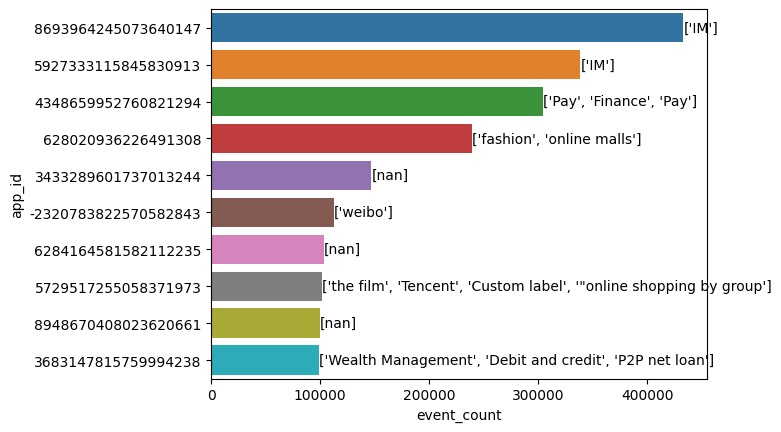

In [ ]:
ax = sns.barplot(top_frequent_apps, y='app_id', x='event_count', orient='h')
ax.bar_label(ax.containers[0], labels=top_frequent_apps['category'], fmt='%g')
plt.show()

The most popular apps are social apps and apps related to shopping and online payments.

### c) Top 10 mobile phone brands by age groups

In [ ]:
# Create age bins
phone_brand_count = train_mobile_brand[['age', 'phone_brand']]
phone_brand_count['age_bin'] = pd.cut(
    train_mobile_brand['age'],
    [0, 24, 32, 45, 100],
)
# Group devices by age_bin and phone brand then count them
phone_brand_count = phone_brand_count.groupby(['age_bin', 'phone_brand'])['phone_brand'].count()
# Get top 10 brands per age bin
top_brands_by_age_group = phone_brand_count.groupby('age_bin').nlargest(10)
# We got duplicate index, so just drop one of them
top_brands_by_age_group = top_brands_by_age_group.droplevel(0)
# Swap index age_bin↔phone_brand
top_brands_by_age_group = top_brands_by_age_group.swaplevel(0,1)
# Sort descending in order to plot
top_brands_by_age_group = top_brands_by_age_group.unstack()
top_brands_by_age_group = top_brands_by_age_group.loc[
    top_brands_by_age_group.sum(axis=1).sort_values(ascending=False).index
]
top_brands_by_age_group

age_bin,"(0, 24]","(24, 32]","(32, 45]","(45, 100]"
phone_brand,,,,
Xiaomi,4235.0,7556.0,4005.0,1541.0
samsung,2370.0,5569.0,4183.0,1584.0
Huawei,2449.0,5122.0,3976.0,1454.0
OPPO,1861.0,2378.0,1185.0,378.0
vivo,1980.0,2329.0,1016.0,333.0
Meizu,1687.0,2057.0,690.0,276.0
Coolpad,811.0,1213.0,943.0,382.0
lenovo,614.0,1005.0,739.0,337.0
Gionee,328.0,400.0,279.0,117.0


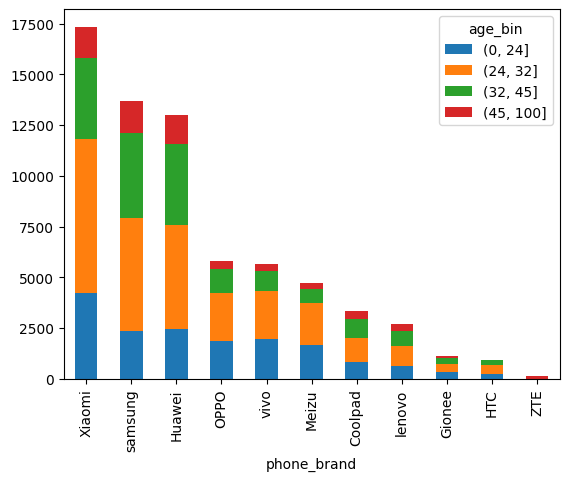

In [ ]:
top_brands_by_age_group.plot.bar(stacked=True)
plt.show()

People from age group 25-32 are the majority in top brands. An interesting fact is that ZTE brand is only used by the elder people from age group 45-100 but no elder people uses HTC.

## 4. Feature engineering

### a) Average daily events for each devices

There is a clear sign of relation between the time active on phone and gender/age as we can see while doing EDA above. So this maybe a good feature to have.

In [ ]:
events_per_day = train_event_data[~train_event_data['event_id'].isna()]
events_per_day['datetimestamp'] = (
    events_per_day['datetimestamp'].dt.to_period('d')
)
events_per_day = events_per_day.groupby(['device_id', 'datetimestamp'])['event_id'].sum()
feature_average_daily_events = events_per_day.reset_index().groupby('device_id')['event_id'].mean()
feature_average_daily_events = feature_average_daily_events.rename('average_daily_events')
feature_average_daily_events

device_id
-9222956879900150000    4.524564e+07
-9221026417907250000    3.711151e+07
-9220830859283100000    4.175564e+06
-9220061629197650000    1.154161e+07
-9218960997324660000    1.588706e+06
                            ...     
 9216925254504440000    2.976483e+07
 9217638755105360000    1.957215e+06
 9219164468944550000    1.809837e+08
 9219842210460030000    6.756232e+06
 9220914901466450000    8.211310e+06
Name: average_daily_events, Length: 23310, dtype: float64

In [ ]:
# Save for later
feature_average_daily_events.to_csv('data/feature_average_daily_events.csv')
os.listdir('data')

['app_events.csv',
 'train_event_data.csv',
 'app_events_meta_data.csv',
 'train_mobile_brand.csv',
 'feature_average_daily_events.csv']

---
We have created 1 feature into csv file at `data/feature_average_daily_events.csv`.

For other data columns, there is no sign that effective features can be generated from them after doing EDA:
- As location data is not reliable enough since location can be disabled and enabled anytime on user's devices, making new features from that will just add more noise to the train data so we don't do it.
- Patterns from app categories can be learned easily by the model so no need to put effort into engineering them.